In [138]:
#!pip install git+https://github.com/rtqichen/torchdiffeq

In [198]:
import numpy as np
import scipy.io
import time
import matplotlib.pyplot as plt
import torch
import copy
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
from IPython.display import display, clear_output
gpu = '0'
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

In [140]:
data_size = 400
train_size = 400
leave_out_for_time_test = block_size - train_size
batch_time = 100
batch_size = 20
niters = 2000
freq = 100
scaled = False
zeroflow = True
latent_dim = 2
n_params = 1

n_ensemble = 20
n_hidden = 50

data_noise = 0.001
n_data = batch_time
W1_var = 20. 
W_last_var = 1/n_hidden
W1_lambda = data_noise/W1_var
b1_var = W1_var
b1_lambda =  data_noise/b1_var
W_last_lambda = data_noise/W_last_var


In [141]:
train_mat = scipy.io.loadmat('../input/aedlrom/S_latent_train_20_DLROM.mat')
test_mat = scipy.io.loadmat('../input/aedlrom/S_latent_test_20_DLROM.mat')
train_set = torch.tensor(train_mat['S'])
test_set = torch.tensor(test_mat['S'])

In [142]:
train_set = train_set[:data_size,:]

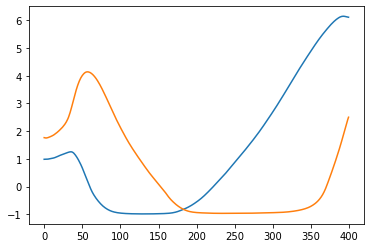

In [143]:
plt.plot(train_set)

In [144]:
scaling = train_set.max() if scaled else 1
train_set = torch.unsqueeze(train_set[:400,:],1)/scaling

In [145]:
def get_batch():
        # randomly select initial time t0 for the batches
        # get randomly n_batches starting point by leaving the last n_test_batches batch for testing
        t = torch.arange(data_size).float()
        s = torch.from_numpy(np.random.choice(np.arange(data_size-batch_time, dtype=np.int64), batch_size, replace=False))
        # select the initial value for each batch
        batch_y0 = train_set[s].float()  # (M, D)
        batch_t = torch.arange(batch_time).float()  # (T)
        batch_y = torch.stack([train_set[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
        return batch_y0.to(device), batch_y.to(device),batch_t.to(device), t[s].to(device)

In [146]:
batch_u0, batch_u, batch_t, ts = get_batch()
batch_u0.shape, batch_u.shape, batch_t.shape

(torch.Size([20, 1, 2]), torch.Size([100, 20, 1, 2]), torch.Size([100]))

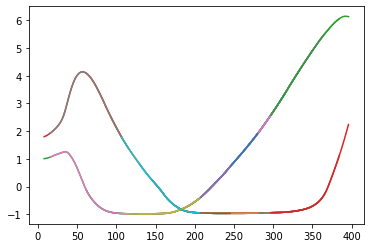

In [147]:
# VISUAL CHECK OF BATCHED DATA

with torch.no_grad():
    batch_u0, batch_u, batch_t,ts = get_batch()
    for i in range(batch_size):
        plt.plot(ts[i].cpu()+batch_t.cpu(), batch_u[:,i,:,0].cpu())
        plt.plot(ts[i].cpu()+batch_t.cpu(), batch_u[:,i,:,1].cpu())


In [148]:
class ODEfun(nn.Module):
    def __init__(self):
        super(ODEfun, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2,n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden,2)
        )
        
        
    def forward(self, t, y):
        return self.net(y)

In [193]:
func = ODEfun().to(device)

In [199]:
lrate = 1e-3
optimizer = optim.RMSprop(func.parameters(), lr=lrate)
itr_time = []
loss_array = []
minloss = 10e5
for itr in range(1, niters + 1):

        start_itr = time.time()
        batch_u0, batch_u, batch_t, _ = get_batch()
        pred_u = odeint(func, batch_u0, batch_t).to(device)
        
        loss = torch.mean(torch.abs(pred_u- batch_u))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        itr_time.append(time.time()-start_itr)
        loss_array.append(loss.item())
        clear_output(wait=True)
        display('Iter ' + str(itr)+'/'+str(niters) + '  |  Loss: ' + str(round(loss.item(),6)))
        
        if loss.item() < minloss:
            bestfun = copy.deepcopy(func)
            minloss = loss.item()
            
        if itr % freq == 0:
            with torch.no_grad():
                print('Iter ' + str(itr)+'/'+str(niters) + '\t|  Loss: ' + str(round(loss.item(),6)) + '\t|  lr: ' + str(optimizer.param_groups[0]['lr']) + '\t|  itr time: ' +str(round(itr_time[-1],5))+' s')
                #       visualize(true_u, pred_u, func, ii, batch_u0, batch_t)
                #       ii += 1


'Iter 2000/2000  |  Loss: 0.425076'

Iter 2000/2000	|  Loss: 0.425076	|  lr: 0.001	|  itr time: 0.2676 s


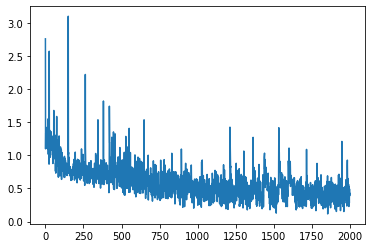

In [200]:
plt.plot(loss_array)

In [202]:
with torch.no_grad():
    batch_u0, batch_u, batch_t, ts = get_batch()
    pred_u = odeint(func, batch_u0, batch_t)

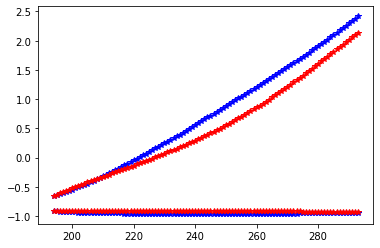

In [203]:
batch_idx = 0
plt.plot(ts[batch_idx].cpu()+batch_t.cpu(), batch_u[:,batch_idx,:,0].cpu(),'*b')
plt.plot(ts[batch_idx].cpu()+batch_t.cpu(), batch_u[:,batch_idx,:,1].cpu(),'*b')
plt.plot(ts[batch_idx].cpu()+batch_t.cpu(), pred_u[:,batch_idx,:,0].cpu(),'*r')
plt.plot(ts[batch_idx].cpu()+batch_t.cpu(), pred_u[:,batch_idx,:,1].cpu(),'*r')


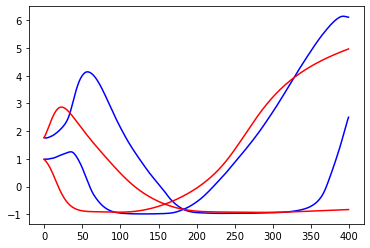

In [204]:
u0 = train_set[0,:,:].to(device)
u0 = u0.unsqueeze(1).float()

with torch.no_grad():
    test_size = 400
    test_t = torch.arange(test_size).float().to(device)
    pred_u = odeint(func, u0, test_t)
    plt.plot(test_t.cpu(), train_set[:,0,:].cpu(),'-b')
    plt.plot(test_t.cpu(), pred_u[:,0,0,:].cpu(),'-r')


## Fine

In [210]:
lrate = 1e-4
optimizer = optim.Adam(bestfun.parameters(), lr=lrate)
itr_time = []
loss_array = []
minloss = 10e5
for itr in range(1, 1000 + 1):

        start_itr = time.time()
        batch_u0, batch_u, batch_t, _ = get_batch()
        pred_u = odeint(bestfun, batch_u0, batch_t).to(device)
        
        loss = torch.mean(torch.abs(pred_u- batch_u))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        itr_time.append(time.time()-start_itr)
        loss_array.append(loss.item())
        clear_output(wait=True)
        display('Iter ' + str(itr)+'/'+str(niters) + '  |  Loss: ' + str(round(loss.item(),6)))
        
        if loss.item() < minloss:
            bestfun_fine = copy.deepcopy(bestfun)
            minloss = loss.item()

            if itr % freq == 0:
                with torch.no_grad():
                    print('Iter ' + str(itr)+'/'+str(niters) + '\t|  Loss: ' + str(round(loss.item(),6)) + '\t|  lr: ' + str(optimizer.param_groups[0]['lr']) + '\t|  itr time: ' +str(round(itr_time[-1],5))+' s')
                    #       visualize(true_u, pred_u, bestfun, ii, batch_u0, batch_t)
                    #       ii += 1


'Iter 1000/2000  |  Loss: 0.052745'

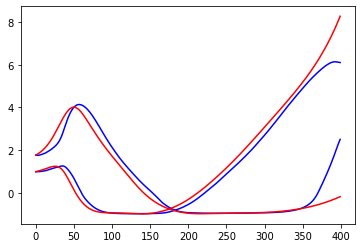

In [211]:
u0 = train_set[0,:,:].to(device)
u0 = u0.unsqueeze(1).float()

with torch.no_grad():
    test_size = 400
    test_t = torch.arange(test_size).float().to(device)
    pred_u = odeint(bestfun_fine, u0, test_t)
    plt.plot(test_t.cpu(), train_set[:,0,:].cpu(),'-b')
    plt.plot(test_t.cpu(), pred_u[:,0,0,:].cpu(),'-r')
